In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. 데이터 로드 + 훈련데이터와 테스트 데이터로 나누기

In [35]:
cafe_reviews = pd.read_csv('C:/Users/User/Desktop/cafe_reviews.csv', encoding='utf-8') 
# 리뷰 4100개

In [36]:
from sklearn.model_selection import train_test_split 
# 훈련 데이터와 테스트 데이터를 랜덤으로 나누어 주기 위해 train_test_split import 해온다.
# 이 라이브러리를 사용하면 두 데이터에 0과 1을 골고루 섞어줄 수 있다.

In [37]:
train_data, test_data = train_test_split(cafe_reviews, random_state=42)

In [38]:
print(train_data.shape) # 훈련 데이터 3130개

(3130, 61)


In [39]:
print(test_data.shape) # 테스트 데이터 1044개

(1044, 61)


In [40]:
train_data = train_data[["review", "label"]] # 결측치 부분 제거
train_data

,review,label
2025,직원 인사도 응대도 잘 안하고 불친절 음료값 비쌈 밤에 가면 한옥뷰 잘 안보이니 참...,0.0
1068,비싸고 불친정... 지저분함... 건조대가 너저분히 있고...,0.0
247,카눌레 처음먹어봤는데 찐맛집이에요 !,1.0
1450,커피는 맛있는데 분위기가 어수선해요.,0.0
1602,연휴라서 사람이 많아요,1.0
...,...,...
3444,디저트맛집입니다 분위도 좋아요,1.0
466,조용하게 좋아요. 생각보다 사람이 적어요.,1.0
3092,더럽다. 정말 더럽다. 우웩,0.0
3772,가격에 비해 맛없어요. 탄맛났습니다.,0.0


In [41]:
test_data = test_data[["review", "label"]]# 결측치 부분 제거
test_data

,review,label
501,또 방문하고 싶어요,1.0
463,조용하게 좋아요. 생각보다 사람이 적어요.,1.0
1424,사람많고 별로,0.0
1461,화장실 별루~,0.0
3024,2번은 안갈듯,0.0
...,...,...
3945,"친절하고 커피 크로와상 다 맛있어요.분위기가 좋은데, 음악이 카페와 어울리지않는듯,...",0.0
3753,"개당25000원이라는 가격을 생각한다면 경악스러운 맛. 분위기는 좋아요, 스모어는 ...",0.0
0,주차시설좋고 넓고 깔끔하고 좋아요. 집 근처라 더욱 좋네요,1.0
3674,너무 기대가 컷는지 빵 생각보다 쏘쏘 대체로 너무 달다 실내가 울려서 많이 시끄러움...,0.0


## 2. 데이터 정제하기

In [42]:
train_data['review'].nunique() # 데이터 중복 유무를 확인

2816

In [43]:
train_data.drop_duplicates(subset=['review'], inplace=True) # 중복 샘플 제거

In [44]:
len(train_data) # 중복 샘플 제거 확인
# 2816이 나온 것으로 중복에 제거된 걸 알 수 있다. 

2816

   label  count
0    0.0   1474
1    1.0   1342


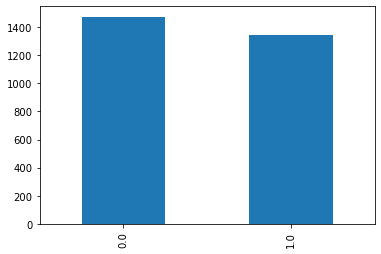

In [45]:
train_data['label'].value_counts().plot(kind = 'bar')
print(train_data.groupby('label').size().reset_index(name = 'count')) 
# 0과 1이 골고루 있다. 

In [25]:
print(train_data.isnull().values.any()) # Null이 있는가?

True


In [26]:
# Null이 존재한다. 어느 열에 있는걸까?
print(train_data.isnull().sum())

review    0
label     1
dtype: int64


In [28]:
# label 열에 Null 존재
# 인덱스를 파악하자
train_data.loc[train_data.label.isnull()]

,review,label
2240,친절하세요 감사합니다,NaN


#### 친절하세요 감사합니다는 긍정이다. 데이터를 수정하고 앞의 과정을 다시 반복해주었다.


In [46]:
print(train_data.isnull().values.any()) # Null이 있는지 다시 해본다. 
# False가 나와야 한다. 

False


In [47]:
# 한글과 공백을 제외하고 모두 제거한다.
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10552\2006357769.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,review,label
2025,직원 인사도 응대도 잘 안하고 불친절 음료값 비쌈 밤에 가면 한옥뷰 잘 안보이니 참...,0.0
1068,비싸고 불친정 지저분함 건조대가 너저분히 있고,0.0
247,카눌레 처음먹어봤는데 찐맛집이에요,1.0
1450,커피는 맛있는데 분위기가 어수선해요,0.0
1602,연휴라서 사람이 많아요,1.0


In [48]:
train_data['review'] = train_data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['review'].replace('', np.nan, inplace=True)
# 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것
print(train_data.isnull().sum())


review    10
label      0
dtype: int64


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10552\2741008587.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [49]:
# Null 값이 10개 생김
train_data.loc[train_data.review.isnull()]

,review,label
1831,NaN,1.0
313,NaN,1.0
3280,NaN,1.0
1807,NaN,1.0
3275,NaN,1.0
4166,NaN,1.0
92,NaN,1.0
1838,NaN,1.0
1782,NaN,1.0
4142,NaN,1.0


In [50]:
train_data = train_data.dropna(how = 'any') # Null 값 10개 없애준다.
print(len(train_data)) # 2816 => 2806

2806


In [51]:
# 테스트 데이터에서도 똑같이 전처리 과정 수행

test_data.drop_duplicates(subset = ['review'], inplace=True) # review 열에서 중복인 내용이 있다면 중복 제거
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['review'] = test_data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트 데이터의 개수 :',len(test_data))

전처리 후 테스트 데이터의 개수 : 927


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10552\866505090.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10552\866505090.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['review'] = test_data['review'].str.replace('^ +', "") # 공백은 empty 값으로 변경


## 3. 토큰화

In [52]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', 'ㅠ', 'ㅠㅠ', 'ㅜㅜ', 'ㅋㅋ', 'ㅡㅡ', 'ㅠㅜ', 'ㄱ', 'ㄷㄷㄷ', 'ㅠㅠㅠㅠㅠㅠ', '❤']

In [53]:
# 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장
X_train = []
for sentence in tqdm(train_data['review']):
    okt = Okt() # 형태소 분석기
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 2806/2806 [00:12<00:00, 216.35it/s]


In [54]:
print(X_train[:3]) # 상위 3개

[['직원', '인사', '응대', '자다', '안', '하고', '불친절', '음료', '값', '비싸다', '밤', '가면', '옥뷰', '자다', '안보', '이니', '참고'], ['비싸다', '불', '친정', '지저분하다', '건조대', '너저분하다', '있다'], ['카눌레', '처음', '먹다', '보다', '찌다', '맛집', '이에요']]


In [55]:
# 테스트 데이터에서도 동일하게 진행

X_test = []
for sentence in tqdm(test_data['review']):
    okt = Okt() # 형태소 분석기
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 927/927 [00:02<00:00, 397.67it/s]


In [56]:
print(X_test[:3]) # 상위 3개

[['또', '방문', '하고', '싶다'], ['조용하다', '좋다', '생각', '보다', '사람', '적다'], ['사람', '많다', '별로']]


## 4. 정수 인코딩

In [57]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # 훈련 데이터에 대한 단어 집합 형성

In [58]:
print(tokenizer.word_index)

{'좋다': 1, '너무': 2, '맛있다': 3, '맛': 4, '있다': 5, '커피': 6, '많다': 7, '먹다': 8, '없다': 9, '카페': 10, '음료': 11, '사람': 12, '보다': 13, '가격': 14, '오다': 15, '같다': 16, '을': 17, '직원': 18, '비싸다': 19, '뷰': 20, '친절하다': 21, '이다': 22, '곳': 23, '않다': 24, '안': 25, '분위기': 26, '요': 27, '가다': 28, '빵': 29, '분': 30, '다': 31, '되다': 32, '로': 33, '매장': 34, '정말': 35, '넓다': 36, '자리': 37, '케이크': 38, '에서': 39, '만': 40, '아니다': 41, '별로': 42, '넘다': 43, '하고': 44, '층': 45, '방문': 46, '공부': 47, '주문': 48, '그렇다': 49, '그냥': 50, '진짜': 51, '디저트': 52, '고': 53, '많이': 54, '것': 55, '들다': 56, '예쁘다': 57, '자다': 58, '나오다': 59, '크다': 60, '불친절하다': 61, '종류': 62, '생각': 63, '때': 64, '랑': 65, '못': 66, '시간': 67, '테이블': 68, '엄청': 69, '인': 70, '수': 71, '조용하다': 72, '손님': 73, '인데': 74, '주차': 75, '더': 76, 'ㅎㅎ': 77, '시끄럽다': 78, '다른': 79, '화장실': 80, '여수': 81, '인테리어': 82, '안되다': 83, '받다': 84, '싶다': 85, '편하다': 86, '나': 87, '맛집': 88, '아쉽다': 89, '사진': 90, '적': 91, '서': 92, '줄': 93, '사장': 94, '기분': 95, '또': 96, '여기': 97, '공간': 98, '앉다': 99, '분들': 100, '님': 10

In [59]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4699
등장 빈도가 2번 이하인 희귀 단어의 수: 2891
단어 집합에서 희귀 단어의 비율: 61.523728452862315
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.017848088429165


## => 희귀 단어 등장 빈도 비율이 9% 밖에 안되므로 등장 빈도수가 2 이하인 단어들을 제거한다.

In [60]:
# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한

# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1809


In [61]:
# 단어 집합의 크기를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [62]:
print(X_train[:3]) # 정수 인코딩 확인

[[18, 912, 237, 58, 25, 44, 171, 11, 303, 19, 684, 331, 58, 1207, 578], [19, 913, 371, 5], [172, 8, 13, 540, 88, 123]]


In [63]:
# train_data에서 y_train과 y_test를 별도로 저장한다. 모델의 성능을 점검하게 위해서다.
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 5. 빈 샘플 제거

In [64]:
'''
전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 
-> 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미
-> 빈 샘플들을 제거해주는 작업 진행
'''

# 길이가 0인 샘플들의 인덱스를 받아오기
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [65]:
# drop_train에는 X_train으로부터 얻은 빈 샘플들의 인덱스가 저장됨
# 이제 빈 샘플들을 제거해보자.
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

2794
2794


C:\Users\user\anaconda3\lib\site-packages\numpy\lib\function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 6. 패딩

리뷰의 최대 길이 : 120
리뷰의 평균 길이 : 12.844309234073014


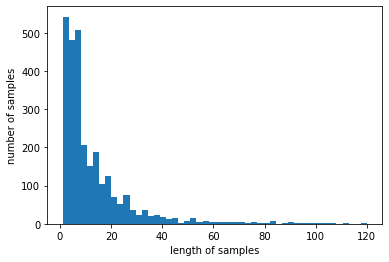

In [66]:
# 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 것이 패딩 작업

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [67]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [68]:
# 위의 분포 그래프를 봤을 때, max_len = 60이 적당할 것 같다.
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 97.74516821760916


In [69]:
# 길이가 60이하인 샘플의 비율이 97.7% => 모든 샘플의 길이를 60으로 통일하자
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

## 7. LSTM으로 카페 리뷰 감성 분류하기

In [70]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
# Embedding: 벡터 공간에서 더 가까운 단어가 예상되도록 단어의 의미를 인코딩하는 실수 값 벡터의 형태로 텍스트 분석을 위한 단어 표현에 사용되는 용어
# Dense: 뉴런의 입력과 출력을 연결
# LSTM: RNN의 한 종류. 단순한 neural network layer 한 층 대신, 4개의 layer가  특별한 방식으로 서로 정보를 주고 받도록 되어 있다.
# LSTM -> 기울기 소멸 문제 방지

from tensorflow.keras.models import Sequential # 순차적으로 레이어 층 더해줌
from tensorflow.keras.models import load_model # 모델 불러오기 함수
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# EarlyStopping: 과적합을 방지하기 위해 조기종료
# ModelCheckpoint: 학습 중인 모델 자동으로 저장하기

embedding_dim = 100 # 임베딩 벡터 차원은 100
hidden_units = 128 # 은닉 상태의 크기는 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid')) # 활성화 함수로 시그모이드 함수 사용. 로지스틱 회귀를 사용해야 하므로
# 로지스틱 회귀분석에서는 종속변수가 0 또는 1이기 때문에  y=wx+b 을 이용해서 예측하는 것은 의미가 없다

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4) # 조기종료
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True) # 자동 저장

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc']) # 손실함수: binary_crossentropy. 이진 분류에 적합
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2) # 검증데이터는 20% 사용

Epoch 1/15
35/35 [==============================] - ETA: 0s - loss: 0.6594 - acc: 0.7700
Epoch 1: val_acc improved from -inf to 0.87299, saving model to best_model.h5
35/35 [==============================] - 5s 81ms/step - loss: 0.6594 - acc: 0.7700 - val_loss: 0.4501 - val_acc: 0.8730
Epoch 2/15
35/35 [==============================] - ETA: 0s - loss: 0.3482 - acc: 0.8895
Epoch 2: val_acc improved from 0.87299 to 0.90340, saving model to best_model.h5
35/35 [==============================] - 2s 57ms/step - loss: 0.3482 - acc: 0.8895 - val_loss: 0.3129 - val_acc: 0.9034
Epoch 3/15
34/35 [============================>.] - ETA: 0s - loss: 0.2116 - acc: 0.9274
Epoch 3: val_acc improved from 0.90340 to 0.91055, saving model to best_model.h5
35/35 [==============================] - 2s 58ms/step - loss: 0.2108 - acc: 0.9280 - val_loss: 0.2898 - val_acc: 0.9106
Epoch 4/15
35/35 [==============================] - ETA: 0s - loss: 0.1529 - acc: 0.9459
Epoch 4: val_acc did not improve from 0.9105

In [71]:
loaded_model = load_model('best_model.h5') # 훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5'를 로드
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1])) # 테스트 데이터에 대해서 정확도를 측정 => 모델 검증

29/29 [==============================] - 1s 10ms/step - loss: 0.2499 - acc: 0.9180

 테스트 정확도: 0.9180


## 테스트 정확도가 91%로, 좋은 모델이다.

---

## 8. 리뷰 예측 함수 만들기

In [72]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [73]:
sentiment_predict('맛있어요!')

1/1 [==============================] - 0s 364ms/step
84.53% 확률로 긍정 리뷰입니다.



In [74]:
sentiment_predict('공부하기 좋아요')

1/1 [==============================] - 0s 16ms/step
92.20% 확률로 긍정 리뷰입니다.



In [75]:
sentiment_predict('너무 시끄러워요')

1/1 [==============================] - 0s 16ms/step
91.02% 확률로 부정 리뷰입니다.



In [76]:
sentiment_predict('벌레나오고 알바 싸가지 없음')

1/1 [==============================] - 0s 15ms/step
99.01% 확률로 부정 리뷰입니다.



## Overview 만들어보기 - 스타벅스 대전 장대점

In [77]:
# 함수 재정의. (score * 100)% 확률로 긍정이다를 추출하도록 함

def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  print("{:.2f}% \n".format(score*100)) # (score * 100)% 확률로 긍정

In [78]:
starbucks_reviews = pd.read_csv('C:/Users/User/Desktop/starbucks_jangdaedong.csv', encoding='utf-8')

In [79]:
starbucks_reviews # 스타벅스 대전 장대점 리뷰 데이터

,id,review
0,콩9833,새로 이사온 동네 스벅 접수. 아담하고 왠지 정감 있음~~^^
1,오늘도 벨라,저녁식사 하고 왔어요ㅎㅎ 쑥크림은 콜드브루가 좀 더 많이 들어있으면 했지만 맛있었어...
2,갸냐댜람쥐,맛있어요^_^ 매장이 넓고 좌석이 편해용😙
3,부공자,자바칩♡
4,dr farm43,음료와 커피가 맛있어요~~
...,...,...
577,lov****,굿
578,아그몬,친절하고 좋네요
579,바다7499,친절해요! 로스팅도 좋네요
580,아프리카7484,굿


In [80]:
starbucks_reviews['review'].nunique() # 데이터 중복 유무 확인

293

In [81]:
starbucks_reviews.drop_duplicates(subset=['review'], inplace=True) # 중복 샘플 제거

In [82]:
# 한글과 공백을 제외하고 모두 제거한다.
starbucks_reviews['review'] = starbucks_reviews['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_10552\3866103517.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  starbucks_reviews['review'] = starbucks_reviews['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [83]:
starbucks_reviews # 중복 샘플을 제거하여 인덱스가 엉켜있다.

,id,review
0,콩9833,새로 이사온 동네 스벅 접수 아담하고 왠지 정감 있음
1,오늘도 벨라,저녁식사 하고 왔어요ㅎㅎ 쑥크림은 콜드브루가 좀 더 많이 들어있으면 했지만 맛있었어...
2,갸냐댜람쥐,맛있어요 매장이 넓고 좌석이 편해용
3,부공자,자바칩
4,dr farm43,음료와 커피가 맛있어요
...,...,...
575,은아47,근처라 자주가는곳이에요 직원분들도 친절하시고 사람많이붐비지않는편이고좋아요 지하주차장...
576,딱조아67,여행길에 들른 스타벅스
578,아그몬,친절하고 좋네요
579,바다7499,친절해요 로스팅도 좋네요


In [85]:
starbucks_reviews = starbucks_reviews.reset_index() # 인덱스를 초기화해준다.
starbucks_reviews

,index,id,review
0,0,콩9833,새로 이사온 동네 스벅 접수 아담하고 왠지 정감 있음
1,1,오늘도 벨라,저녁식사 하고 왔어요ㅎㅎ 쑥크림은 콜드브루가 좀 더 많이 들어있으면 했지만 맛있었어...
2,2,갸냐댜람쥐,맛있어요 매장이 넓고 좌석이 편해용
3,3,부공자,자바칩
4,4,dr farm43,음료와 커피가 맛있어요
...,...,...,...
289,575,은아47,근처라 자주가는곳이에요 직원분들도 친절하시고 사람많이붐비지않는편이고좋아요 지하주차장...
290,576,딱조아67,여행길에 들른 스타벅스
291,578,아그몬,친절하고 좋네요
292,579,바다7499,친절해요 로스팅도 좋네요


In [86]:
for i in range(len(starbucks_reviews)): # 스타벅스 리뷰 데이터들을 모두 함수에 넣어 돌려본다.
    sentiment_predict(str(starbucks_reviews.iloc[i]))
    print(i)
    print("---------------------------------------------------------")

1/1 [==============================] - 0s 16ms/step
80.13% 

0
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
97.77% 

1
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
99.11% 

2
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
50.35% 

3
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
84.78% 

4
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
96.96% 

5
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
78.87% 

6
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
93.58% 

7
---------------------------------------------------------
1/1 [===========================

1/1 [==============================] - 0s 13ms/step
39.66% 

134
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
69.70% 

135
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
93.70% 

136
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
85.87% 

137
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
90.03% 

138
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
96.08% 

139
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
90.53% 

140
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
96.75% 

141
---------------------------------------------------------
1/1 [===========

1/1 [==============================] - 0s 15ms/step
47.54% 

201
---------------------------------------------------------
1/1 [==============================] - 0s 15ms/step
90.58% 

202
---------------------------------------------------------
1/1 [==============================] - 0s 15ms/step
62.23% 

203
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
98.87% 

204
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
57.29% 

205
---------------------------------------------------------
1/1 [==============================] - 0s 15ms/step
30.46% 

206
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
23.69% 

207
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
84.47% 

208
---------------------------------------------------------
1/1 [===========

1/1 [==============================] - 0s 14ms/step
95.41% 

268
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
76.85% 

269
---------------------------------------------------------
1/1 [==============================] - 0s 15ms/step
45.12% 

270
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
77.46% 

271
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
80.81% 

272
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
87.49% 

273
---------------------------------------------------------
1/1 [==============================] - 0s 13ms/step
97.97% 

274
---------------------------------------------------------
1/1 [==============================] - 0s 14ms/step
98.26% 

275
---------------------------------------------------------
1/1 [===========

## => %가 높은 인덱스의 리뷰들, 즉 긍정적인 상위 5개 리뷰들을 추출한다. 그리고 이들을 합친다. 이것이 Overview

### 2번 인덱스(99.11%)
### 51번 인덱스(98.94%)
### 228번 인덱스(99.38%) 
### 120번 인덱스(99.61%)
### 231번 인덱스(99.04%)
### 위 다섯개 인덱스에 해당하는 리뷰들이 상위 5개의 리뷰로 뽑을 수 있다. 

### 그러면 Overview는 다음과 같이 나온다.

In [223]:
starbucks_reviews.iloc[2]['review']+" "+ starbucks_reviews.iloc[51]['review']+" "+starbucks_reviews.iloc[228]['review']+" "+starbucks_reviews.iloc[120]['review']+" "+starbucks_reviews.iloc[231]['review']

'맛있어요 매장이 넓고 좌석이 편해용 사무실근처라 자주 오는데 깔끔하고 친절해요 콜드브루  맛있어요ㅎㅎ 쾌적해서 장소도 넓구요 단골벅스 그냥좋음 맛있고 지인분께서 여기가 맛있다고 해서 일부러 들렸어요  친절하고 맛있어요'